<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:3**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, boxcox
import os
import joblib
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

In [2]:
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

Mounted at /content/drive/
/content/drive/My Drive/Flotation


In [23]:
flotation = pd.read_csv('Flotation_Plant_Clean.csv')

##**5. Exploratory Data Analysis**

###**5.1. Dataset summary statistics**

In [11]:
flotation.head().T

,0,1,2,3,4
date,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00
iron_feed,55.2,55.2,55.2,55.2,55.2
silica_feed,16.98,16.98,16.98,16.98,16.98
starch_flow,301.953,302.441,304.346,304.736,303.369
amina_flow,557.434,563.965,568.054,568.665,558.167
pulp_flow,395.713,397.383,399.668,397.939,400.254
pulp_pH,10.07,10.07,10.07,10.07,10.07
pulp_density,1.74,1.74,1.74,1.74,1.74
airflow_col1,249.214,249.719,249.741,249.917,250.203
airflow_col2,253.235,250.532,247.874,254.487,252.136


### **5.2. Variable Reduction**

- Flotation froth level measurements and date do not effect the output silica percentage.
- Then we will drop level columns
- Air flow of seven columns measurements can be merged by taking mean, only one value.  
- Other variables affect the percentage of iron and silica.

In [ ]:
# Drop the level columns
level_columns = ['level_col1', 'level_col2', 'level_col3', 'level_col4',
                 'level_col5', 'level_col6', 'level_col7']
flotation.drop(level_columns, axis=1, inplace=True)

# Drop the 'date' column
flotation.drop('date', axis=1, inplace=True)

# Calculate the mean of the airflow columns
airflow_columns = ['airflow_col1', 'airflow_col2', 'airflow_col3', 'airflow_col4',
                   'airflow_col5', 'airflow_col6', 'airflow_col7']
flotation['airflow_mean'] = flotation[airflow_columns].mean(axis=1)

# Drop the individual airflow columns
flotation.drop(airflow_columns, axis=1, inplace=True)

# Reorder the columns
column_order = ['iron_feed', 'silica_feed', 'starch_flow',
                'amina_flow', 'pulp_flow', 'pulp_pH', 
                'pulp_density', 'airflow_mean', 
                'silica_conc', 'iron_conc']
flotation = flotation[column_order]

In [25]:
flotation.head().T

,0,1,2,3,4
iron_feed,55.200,55.200000,55.200,55.200000,55.200
silica_feed,16.980,16.980000,16.980,16.980000,16.980
starch_flow,301.953,302.441000,304.346,304.736000,303.369
amina_flow,557.434,563.965000,568.054,568.665000,558.167
pulp_flow,395.713,397.383000,399.668,397.939000,400.254
pulp_pH,10.070,10.070000,10.070,10.070000,10.070
pulp_density,1.740,1.740000,1.740,1.740000,1.740
airflow_mean,265.090,264.534286,264.120,265.359714,264.663
silica_conc,1.310,1.310000,1.310,1.310000,1.310
iron_conc,66.910,66.910000,66.910,66.910000,66.910


In [26]:
missing_values = flotation.isnull().sum()

print(missing_values)

iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
airflow_mean    0
silica_conc     0
iron_conc       0
dtype: int64


In [29]:
duplicated_values = flotation.duplicated().sum()

duplicated_values

5

In [17]:
round(flotation.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
iron_feed,726453.0,56.30,5.16,42.74,52.67,56.08,59.72,65.78
silica_feed,726453.0,14.65,6.81,1.31,8.94,13.85,19.60,33.40
starch_flow,726453.0,338.26,146.90,0.20,235.13,326.51,395.92,999.98
amina_flow,726453.0,488.14,91.30,241.67,431.80,504.33,553.34,739.54
pulp_flow,726453.0,397.57,9.71,376.25,394.24,399.24,402.97,418.64
pulp_pH,726453.0,9.77,0.39,8.75,9.53,9.80,10.04,10.81
pulp_density,726453.0,1.68,0.07,1.52,1.65,1.70,1.73,1.85
iron_conc,726453.0,65.05,1.12,62.05,64.37,65.21,65.86,68.01
silica_conc,726453.0,2.33,1.13,0.60,1.44,2.00,3.01,5.53
airflow_mean,726453.0,288.63,18.72,218.46,277.78,298.66,300.46,330.50


In [18]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726453 entries, 0 to 726452
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   iron_feed     726453 non-null  float64
 1   silica_feed   726453 non-null  float64
 2   starch_flow   726453 non-null  float64
 3   amina_flow    726453 non-null  float64
 4   pulp_flow     726453 non-null  float64
 5   pulp_pH       726453 non-null  float64
 6   pulp_density  726453 non-null  float64
 7   iron_conc     726453 non-null  float64
 8   silica_conc   726453 non-null  float64
 9   airflow_mean  726453 non-null  float64
dtypes: float64(10)
memory usage: 55.4 MB


###**5.2. Corellation between the variables**

In [19]:
flotation.corr()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,iron_conc,silica_conc,airflow_mean
iron_feed,1.000000,-0.971883,-0.008466,-0.087737,0.161280,0.007553,-0.125132,0.055895,-0.077120,-0.078959
silica_feed,-0.971883,1.000000,0.018555,0.078228,-0.151153,0.008043,0.103815,-0.044607,0.072722,0.105797
starch_flow,-0.008466,0.018555,1.000000,0.026716,0.027589,0.142341,-0.062867,0.022377,-0.027706,0.090274
amina_flow,-0.087737,0.078228,0.026716,1.000000,0.212814,0.124565,0.655336,-0.110440,0.156840,0.120952
pulp_flow,0.161280,-0.151153,0.027589,0.212814,1.000000,0.118013,0.013252,0.082664,0.008710,-0.155354
pulp_pH,0.007553,0.008043,0.142341,0.124565,0.118013,1.000000,0.116751,0.192456,-0.147278,0.176189
pulp_density,-0.125132,0.103815,-0.062867,0.655336,0.013252,0.116751,1.000000,0.015593,0.046378,-0.019393
iron_conc,0.055895,-0.044607,0.022377,-0.110440,0.082664,0.192456,0.015593,1.000000,-0.800688,0.049599
silica_conc,-0.077120,0.072722,-0.027706,0.156840,0.008710,-0.147278,0.046378,-0.800688,1.000000,-0.163749
airflow_mean,-0.078959,0.105797,0.090274,0.120952,-0.155354,0.176189,-0.019393,0.049599,-0.163749,1.000000


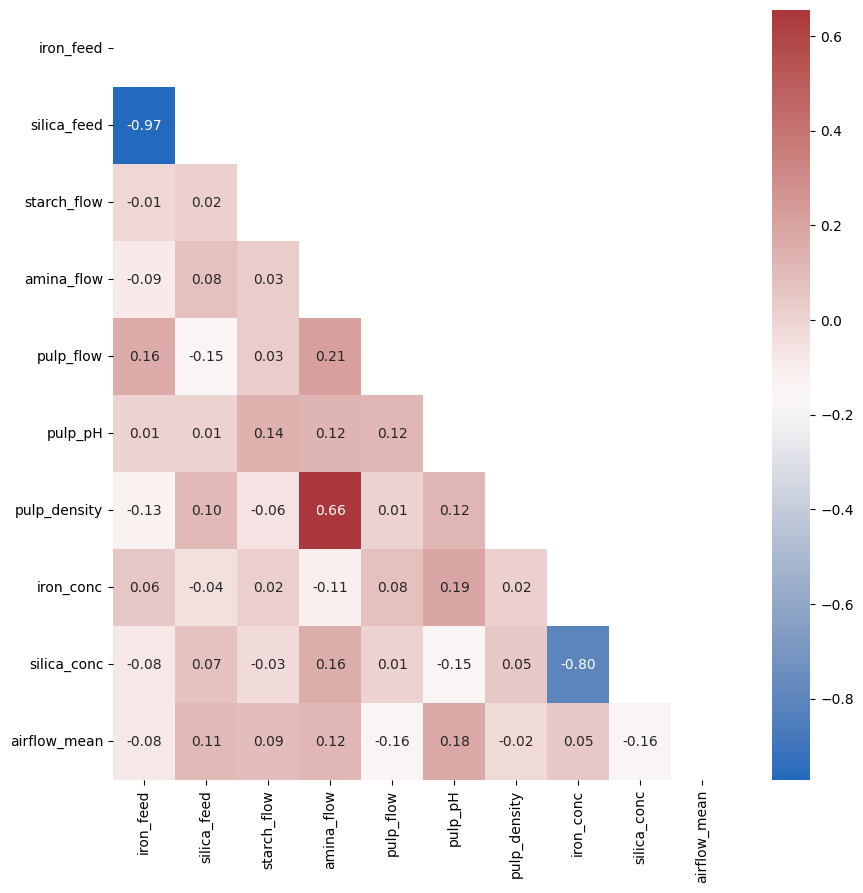

In [21]:
mask = np.triu(np.ones_like(flotation.corr(), dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(flotation.corr(), annot=True, fmt='.2f', cmap='vlag', 
            annot_kws={"fontsize": 10}, mask=mask)
plt.show()

In [ ]:
correlation = flotation.corr().abs()
mask = correlation.mask(np.triu(np.ones(correlation.shape, dtype=bool)))
sorted_correlation = mask.unstack().sort_values(ascending=False)
sorted_correlation = sorted_correlation[(sorted_correlation > 0.65) & (sorted_correlation < 1.0)].reset_index()

# Rename the columns
sorted_correlation.columns = ['variable_1', 'variable_2', 'correlation_degree']

# Reorder the columns
sorted_correlation = sorted_correlation[['variable_1', 'variable_2', 'correlation_degree']]

sorted_correlation

,variable_1,variable_2,correlation_degree
0,iron_feed,silica_feed,0.971883
1,airflow_col1,airflow_col3,0.954339
2,airflow_col2,airflow_col3,0.860341
3,airflow_col6,airflow_col7,0.854030
4,airflow_col1,airflow_col2,0.848209
5,iron_conc,silica_conc,0.800688
6,level_col1,level_col3,0.725207
7,level_col1,level_col2,0.717291
8,level_col5,level_col7,0.710180
9,level_col4,level_col5,0.681514


- Drop highly correlated columns

In [ ]:
flotation.drop(['iron_feed', 'airflow_col1', 'airflow_col2', 'airflow_col7', 'level_col1', 
                'level_col2', 'level_col4', 'level_col6', 'iron_conc'], axis=1, inplace=True)

In [ ]:
flotation.columns

Index(['date', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'airflow_col3', 'airflow_col4',
       'airflow_col5', 'airflow_col6', 'level_col3', 'level_col5',
       'level_col7', 'silica_conc'],
      dtype='object')

###**5.3. Dataset normalisation**

- Normalizing the dataset is necessary to bring the features or variables to a similar scale or range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Select the columns to normalize
columns_to_normalize = ['silica_feed', 'starch_flow', 'amina_flow', 
                        'pulp_flow', 'pulp_pH', 'pulp_density', 
                        'airflow_col3', 'airflow_col4', 'airflow_col5', 
                        'airflow_col6', 'level_col3', 'level_col5',
                        'level_col7', 'silica_conc']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply Min-Max scaling to the selected columns
flotation[columns_to_normalize] = scaler.fit_transform(flotation[columns_to_normalize])


###**5.4. Check & remove outliers**

- Visualize the variables for seeing outliers

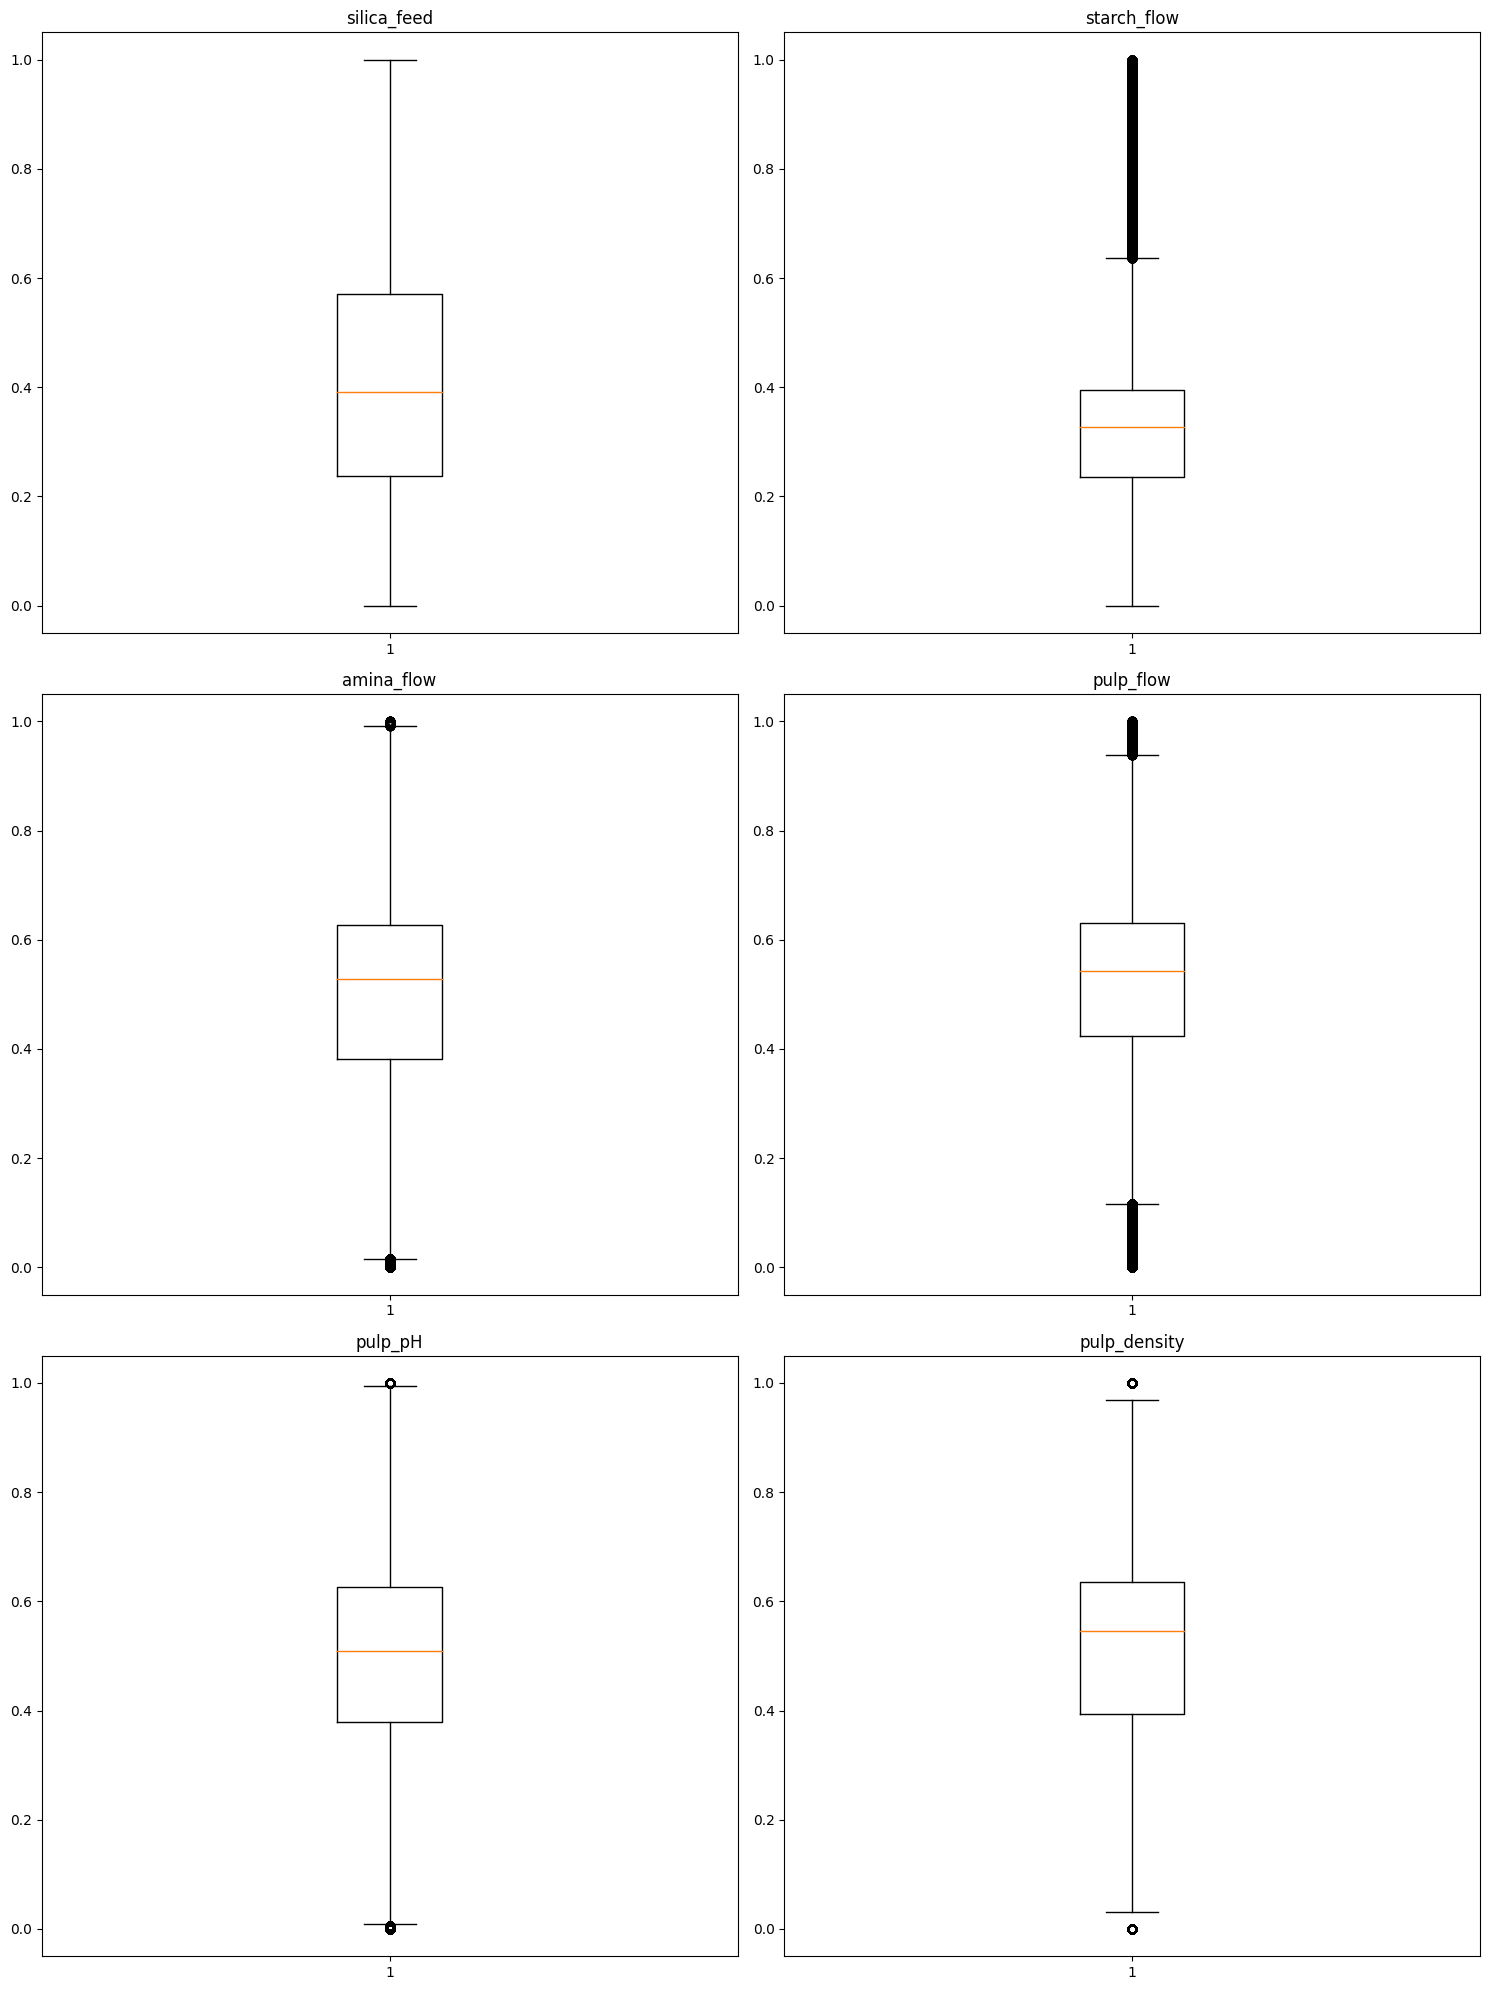

In [ ]:
variables = ["silica_feed", "starch_flow", "amina_flow", 
             "pulp_flow", "pulp_pH", "pulp_density"]

fig, axes = plt.subplots(3, 2, figsize=(15, 20))

for i, variable in enumerate(variables):
    plt.subplot(3, 2, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

plt.tight_layout()
plt.show()

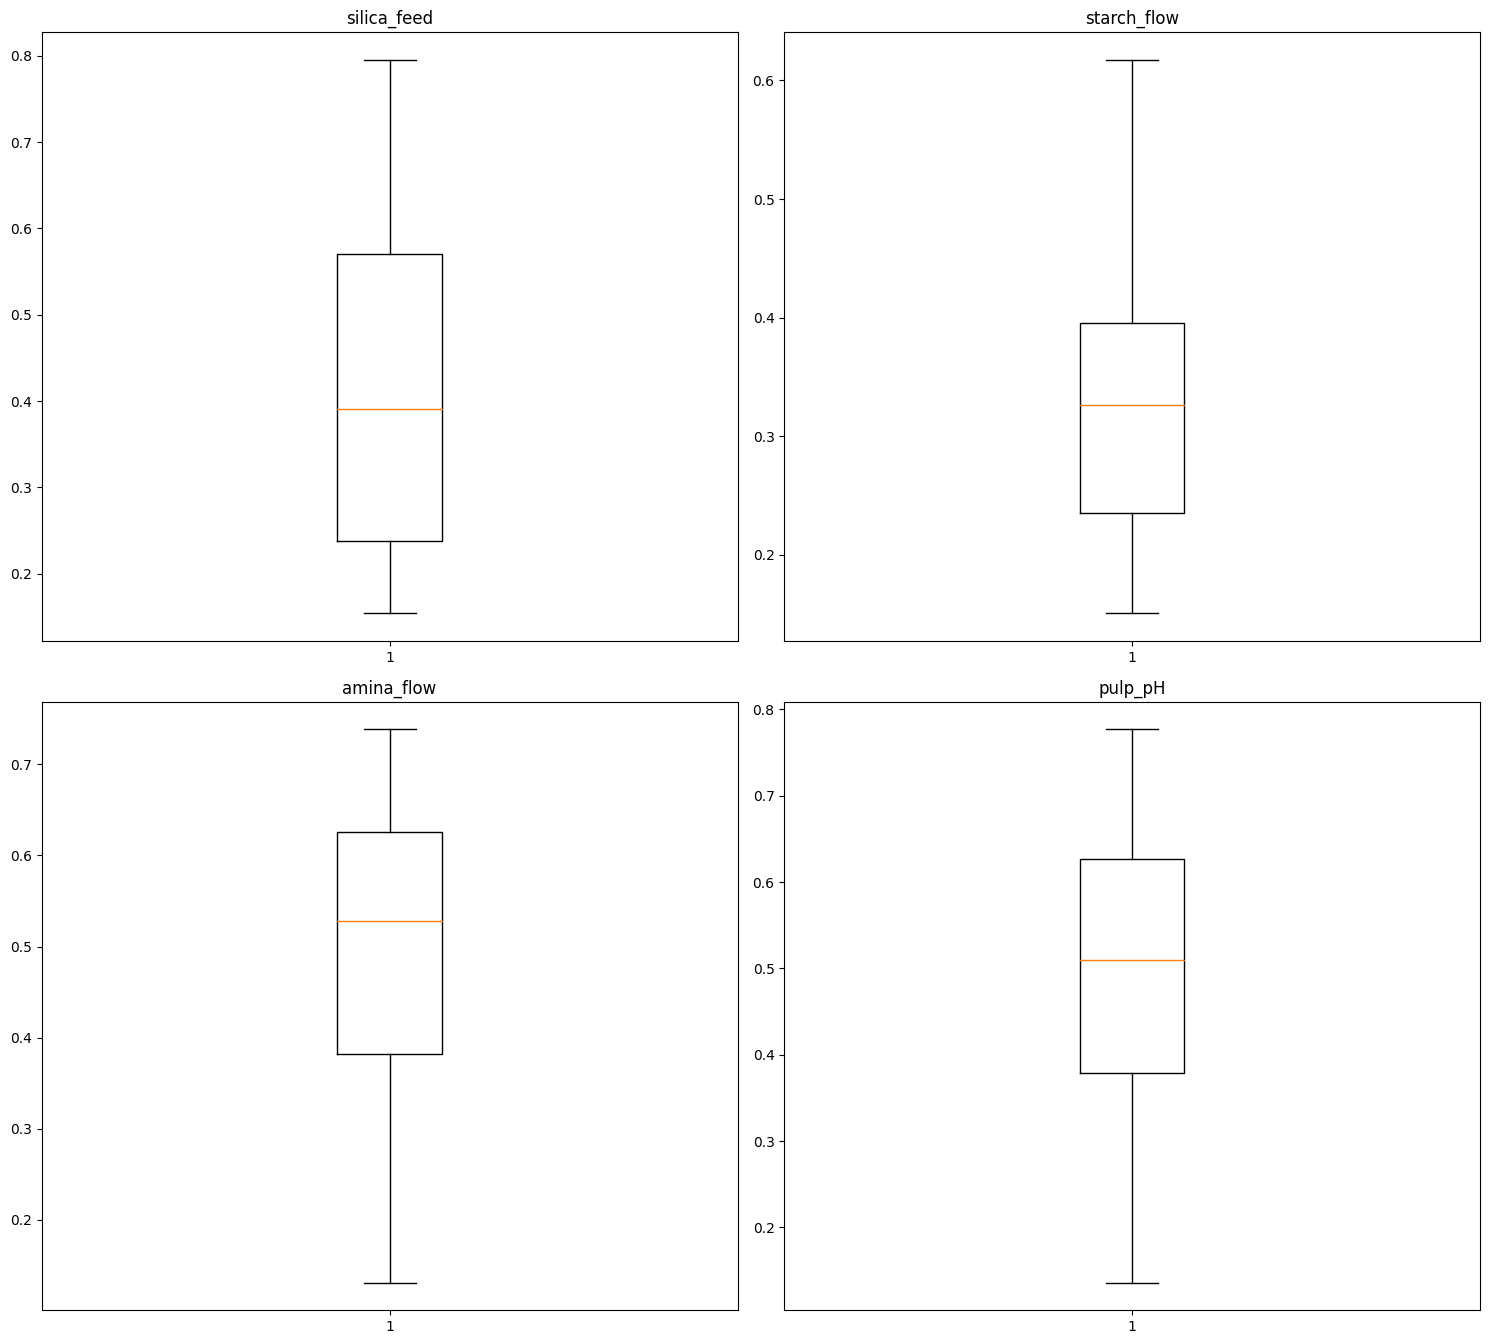

In [ ]:
from scipy.stats.mstats import winsorize

variables = ["silica_feed", "starch_flow", "amina_flow", "pulp_pH",]

fig, axes = plt.subplots(2, 2, figsize=(15, 20))

for i, variable in enumerate(variables):
    plt.subplot(3, 2, i+1)
    data = flotation[variable]
    data_winsorized = winsorize(data, limits=[0.05, 0.05])
    plt.boxplot(data_winsorized)
    plt.title(variable)

plt.tight_layout()
plt.show()

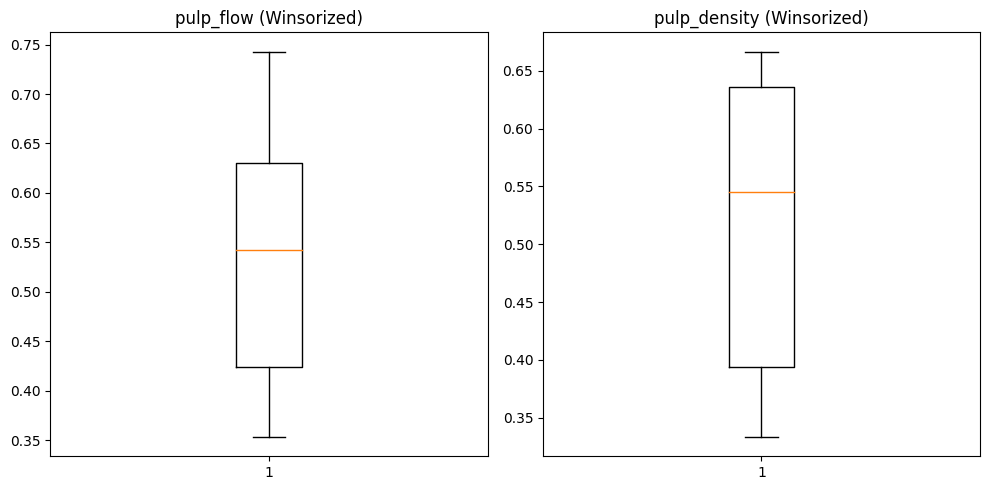

In [ ]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

# Winsorize "pulp_flow" column
pulp_flow_data = flotation["pulp_flow"]
pulp_flow_winsorized = winsorize(pulp_flow_data, limits=[0.2, 0.1])

# Winsorize "pulp_density" column
pulp_density_data = flotation["pulp_density"]
pulp_density_winsorized = winsorize(pulp_density_data, limits=[0.2, 0.2])

plt.figure(figsize=(10, 5))

# Plot boxplot for "pulp_flow" column
plt.subplot(1, 2, 1)
plt.boxplot(pulp_flow_winsorized)
plt.title("pulp_flow (Winsorized)")

# Plot boxplot for "pulp_density" column
plt.subplot(1, 2, 2)
plt.boxplot(pulp_density_winsorized)
plt.title("pulp_density (Winsorized)")

plt.tight_layout()
plt.show()

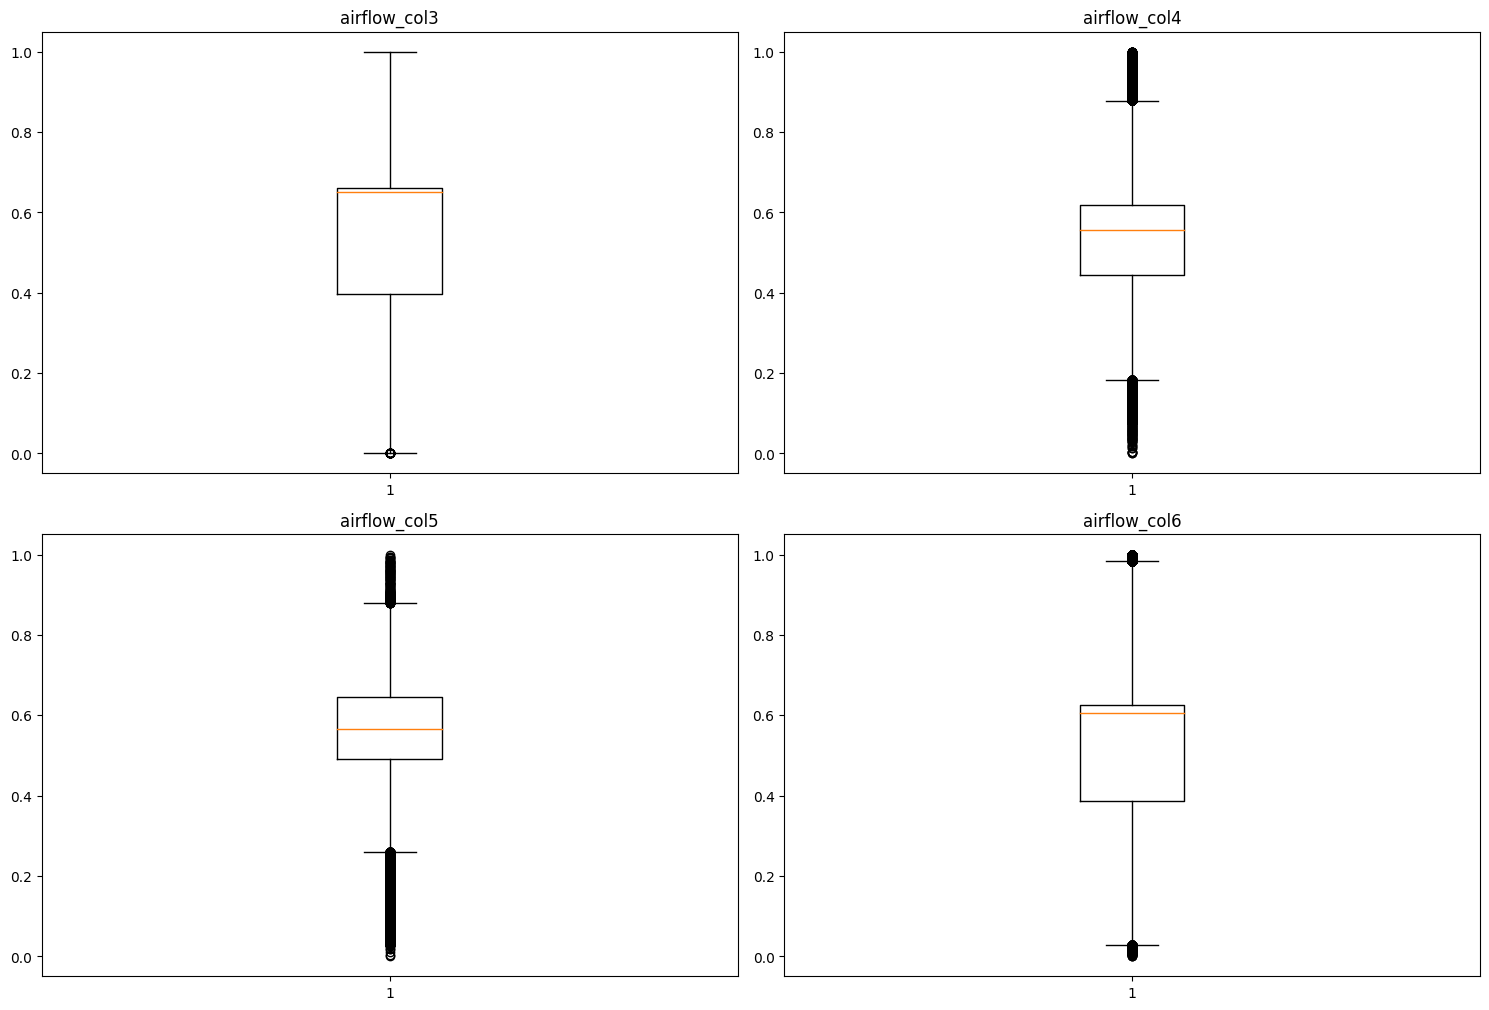

In [ ]:
variables = ["airflow_col3", "airflow_col4", 
             "airflow_col5", "airflow_col6"]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, variable in enumerate(variables):
    plt.subplot(3, 2, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

plt.tight_layout()
plt.show()

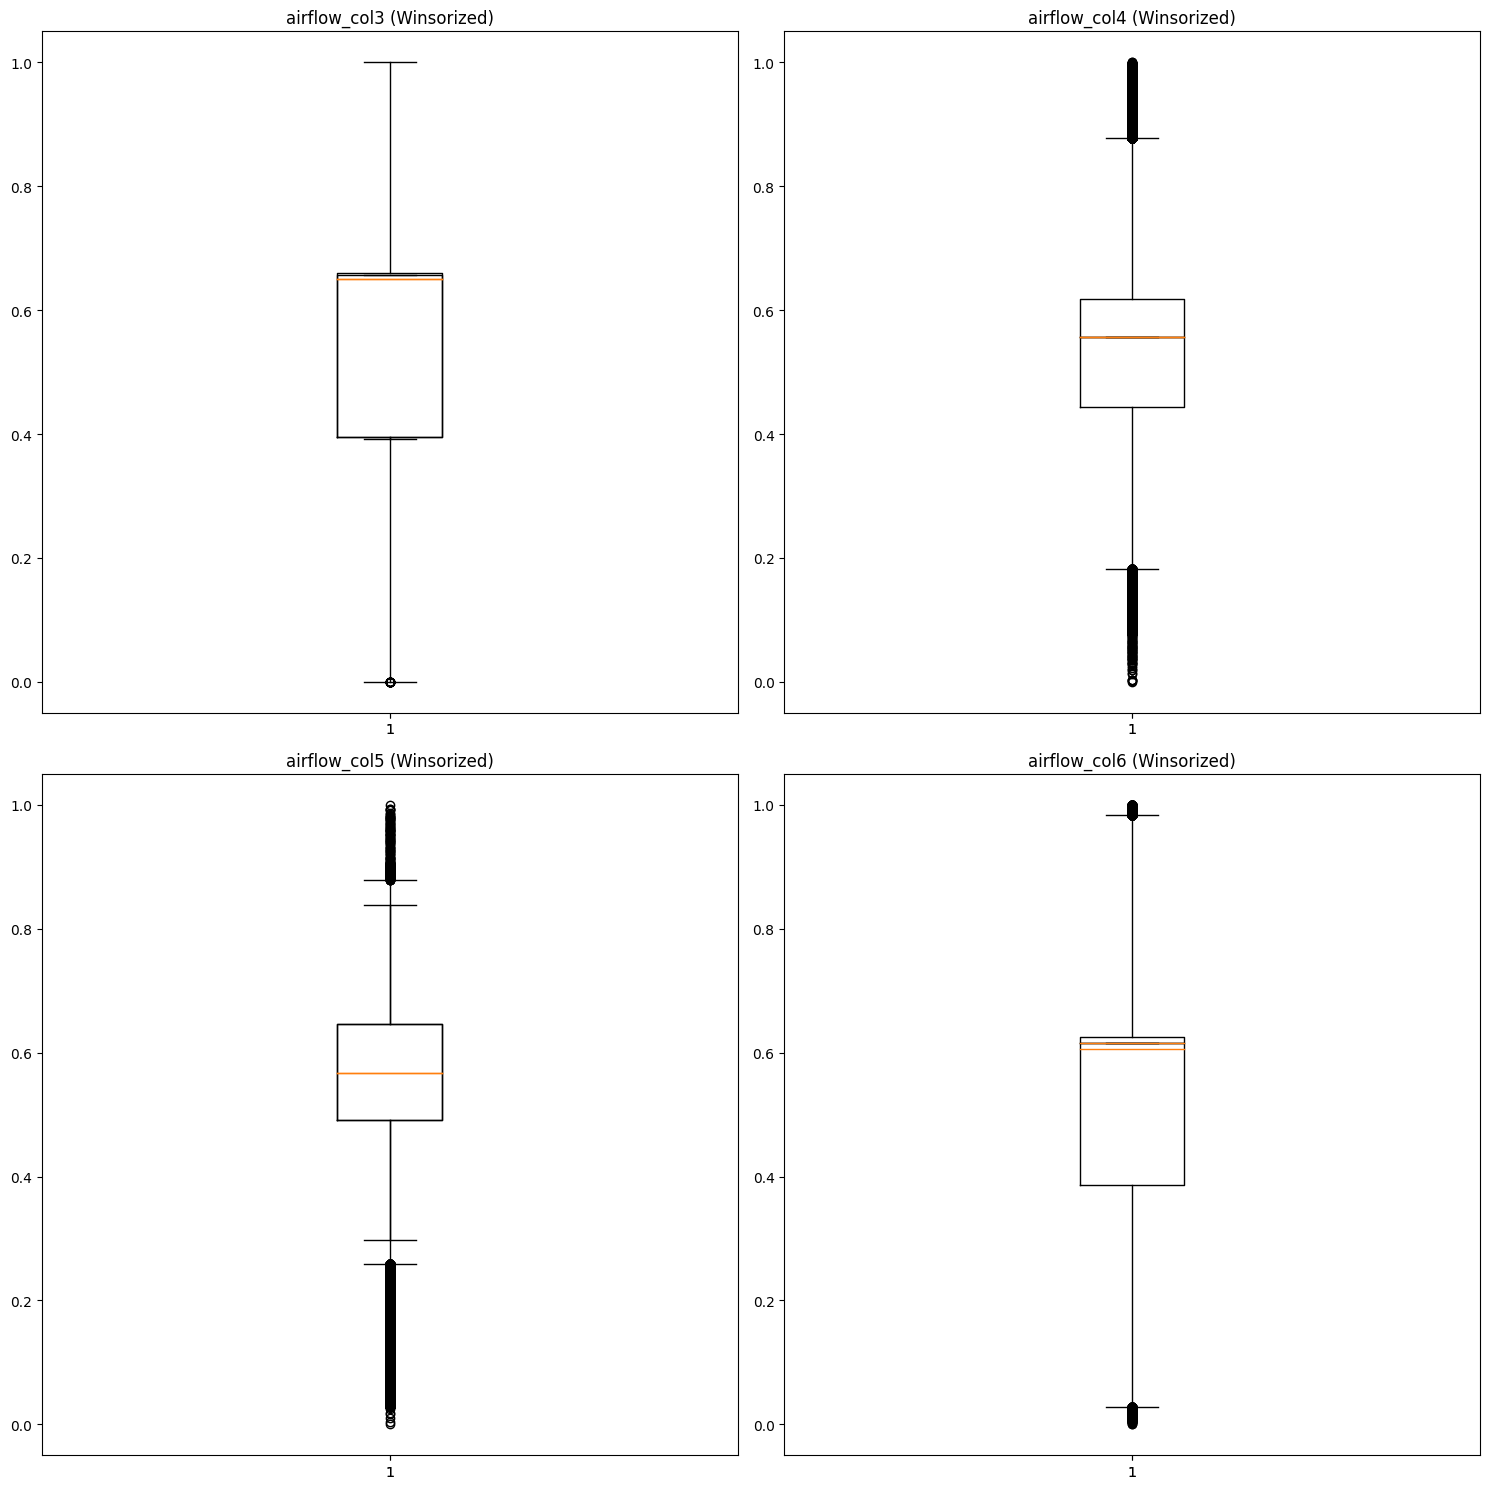

In [ ]:
from scipy.stats.mstats import winsorize

variables = ["airflow_col3", "airflow_col4", "airflow_col5", "airflow_col6"]
limits = {"airflow_col3": [0.2, 0.3], "airflow_col4": [0.5, 0.5], 
          "airflow_col5": [0.05, 0.1], "airflow_col6": [0.7, 0.7]}

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, variable in enumerate(variables):
    plt.subplot(2, 2, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

    # Winsorize the data
    data_winsorized = winsorize(data, limits=limits[variable])

    # Plot the winsorized data
    plt.subplot(2, 2, i+1)
    plt.boxplot(data_winsorized)
    plt.title(variable + " (Winsorized)")

plt.tight_layout()
plt.show()

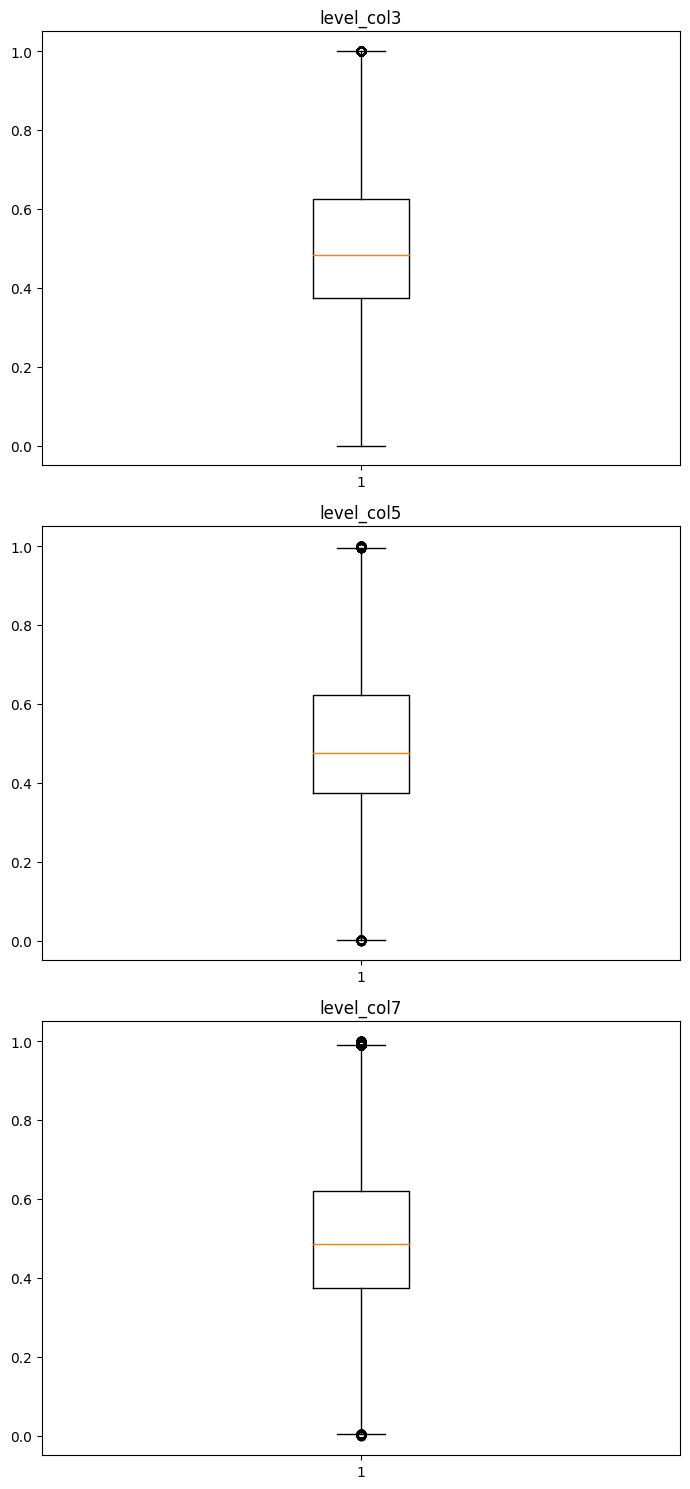

In [ ]:
variables = ["level_col3", "level_col5", "level_col7"]

fig, axes = plt.subplots(3, 1, figsize=(7, 15))

for i, variable in enumerate(variables):
    plt.subplot(3, 1, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

plt.tight_layout()
plt.show()

###**5.5. Check target variable outliers**

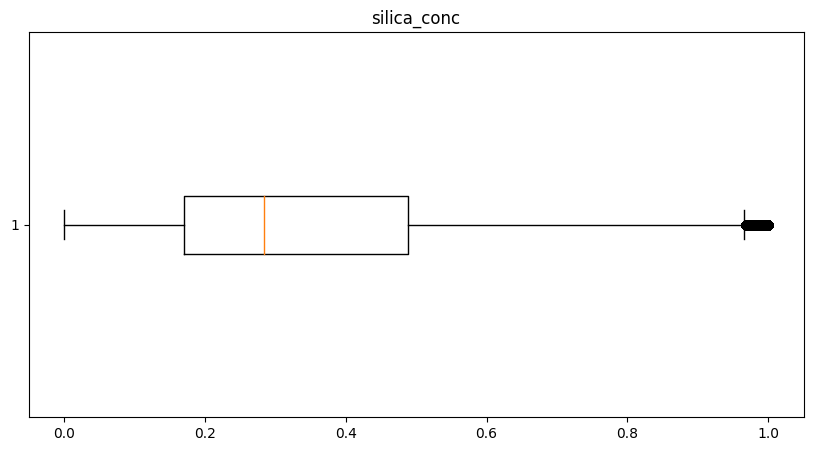

In [ ]:
data = flotation["silica_conc"]
plt.figure(figsize=(10, 5))
plt.boxplot(data, vert=False)
plt.title("silica_conc")

plt.show()

- Eliminate target variable outliers by winsorizing

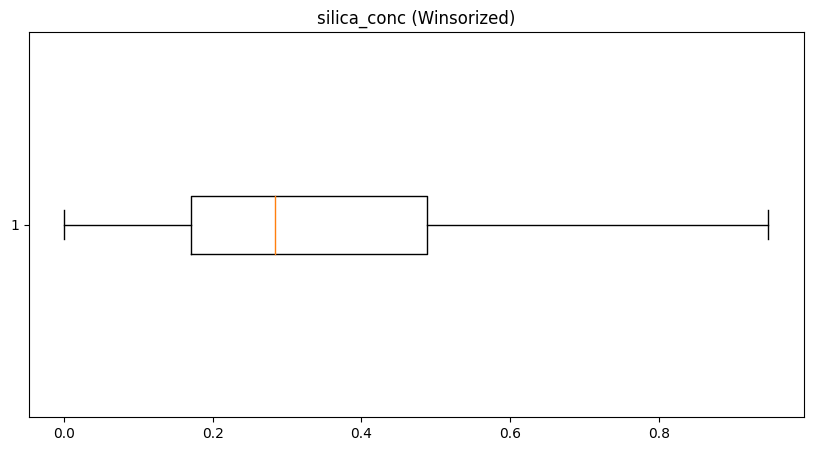

In [ ]:
data_winsorized = winsorize(flotation["silica_conc"], limits=[0, 0.01])
plt.figure(figsize=(10, 5))
plt.boxplot(data_winsorized, vert=False)
plt.title("silica_conc (Winsorized)")

plt.show()

###**5.6. Check the skewness, mean and median of independent variables**

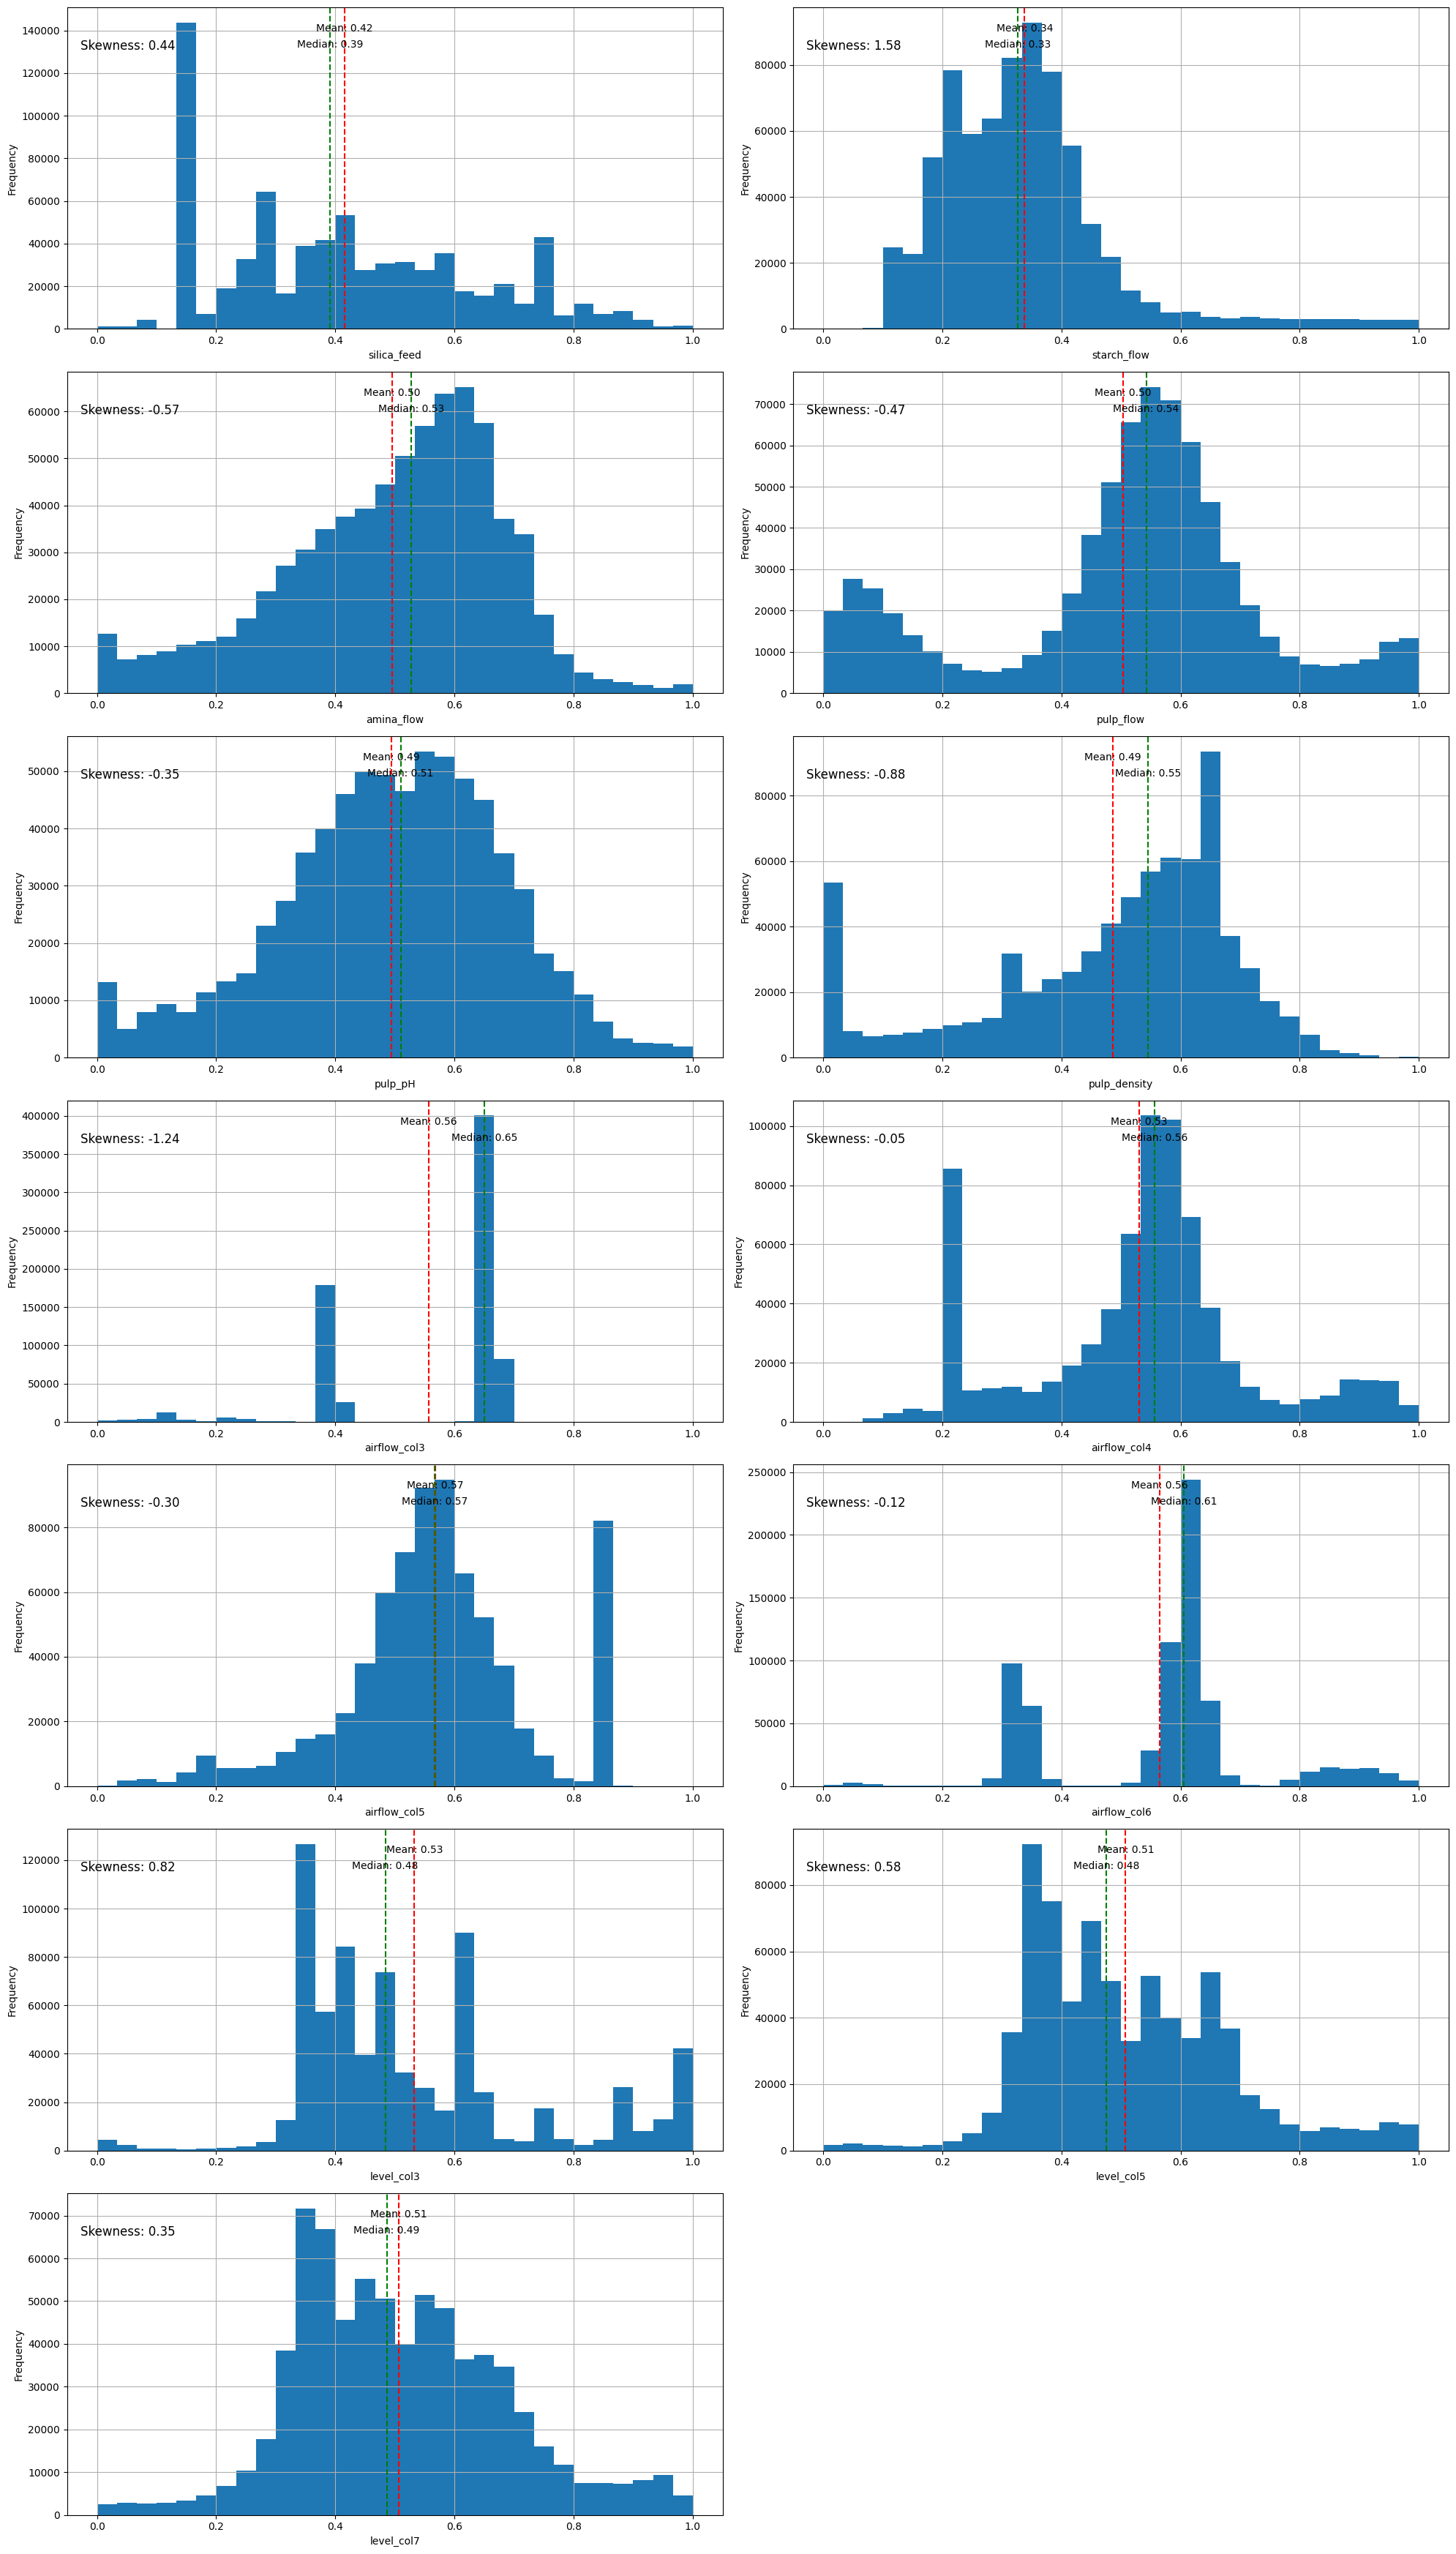

In [ ]:
from scipy.stats import skew

variables = ['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
             'pulp_density', 'airflow_col3', 'airflow_col4', 'airflow_col5',
             'airflow_col6', 'level_col3', 'level_col5', 'level_col7']

num_vars = len(variables)
num_rows = (num_vars + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 5))

for i, variable in enumerate(variables):
    # Select a specific column for skewness calculation
    data = flotation[variable].to_numpy()
    # Calculate the skewness degree
    skewness = skew(data)
    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plotting the variable in the corresponding subplot
    axes[row, col].hist(data, bins=30)
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel("Frequency")
    axes[row, col].axvline(np.mean(data), color='r', linestyle='--')
    axes[row, col].axvline(np.median(data), color='g', linestyle='--')
    # Display the skewness degree in the plot frame
    axes[row, col].text(0.02, 0.9, f"Skewness: {skewness:.2f}",
                        transform=axes[row, col].transAxes, 
                        fontsize=12, verticalalignment='top')
    # Display the mean and median value
    ylim = axes[row, col].get_ylim()
    y_range = ylim[1] - ylim[0]
    axes[row, col].text(np.mean(data), ylim[1] - 0.05 * y_range,
                        f"Mean: {np.mean(data):.2f}", color='black', fontsize=10,
                        verticalalignment='top', horizontalalignment='center')
    axes[row, col].text(np.median(data), ylim[1] - 0.1 * y_range,
                        f"Median: {np.median(data):.2f}", color='black', fontsize=10,
                        verticalalignment='top', horizontalalignment='center')
    axes[row, col].grid(True)

if num_vars % 2 != 0:
    axes[num_rows - 1, 1].axis('off')

plt.tight_layout()
plt.show()

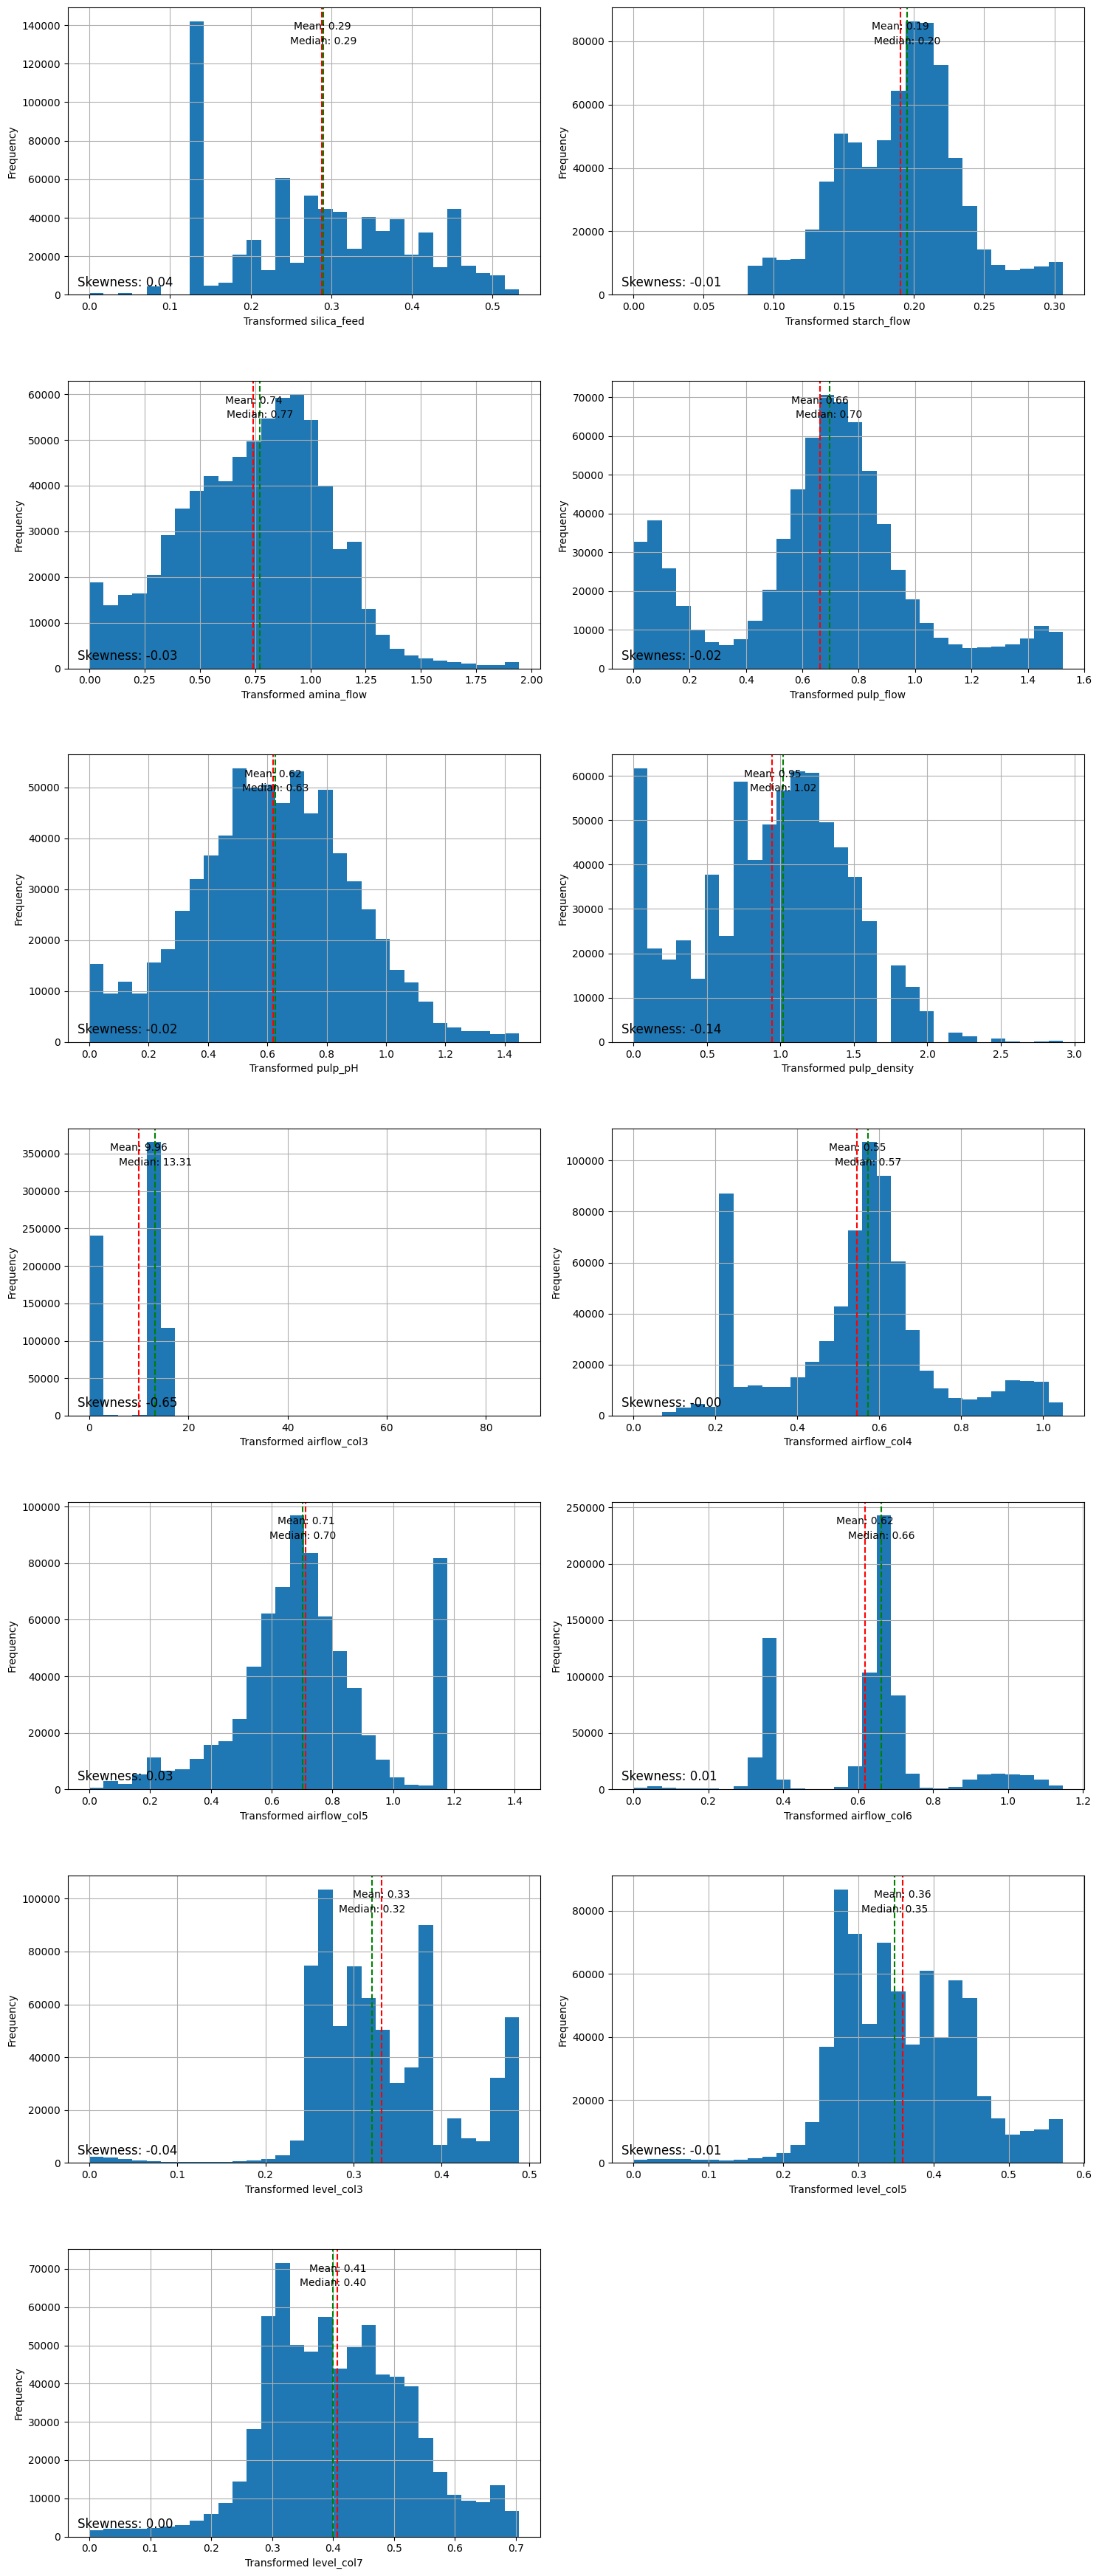

In [ ]:
from scipy.stats import boxcox
from scipy.stats import skew

variables = ['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
             'pulp_density', 'airflow_col3', 'airflow_col4', 'airflow_col5',
             'airflow_col6', 'level_col3', 'level_col5', 'level_col7']

num_variables = len(variables)
num_rows = num_variables // 2 + num_variables % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2
    
    # Select the specific column for transformation
    data = flotation[variable].to_numpy()
    
    # Shift the data by a constant value
    shifted_data = data - np.min(data) + 1  # Add 1 to ensure all values are positive
    
    # Apply the Box-Cox transformation
    data_transformed, lambda_value = boxcox(shifted_data)
    
    # Update the column in the 'flotation' DataFrame with the transformed values
    flotation[variable] = data_transformed
    
    # Calculate the skewness of the transformed data
    skewness_transformed = skew(data_transformed)
    
    # Plot the histogram of the transformed data
    axes[row, col].hist(data_transformed, bins=30)
    axes[row, col].set_xlabel(f'Transformed {variable}')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].axvline(np.mean(data_transformed), color='r', linestyle='--')
    axes[row, col].axvline(np.median(data_transformed), color='g', linestyle='--')
    
    # Display the skewness degree in the plot
    axes[row, col].text(0.02, 0.02, f"Skewness: {skewness_transformed:.2f}", 
                        transform=axes[row, col].transAxes,
                        fontsize=12, verticalalignment='bottom', 
                        horizontalalignment='left')
    
    # Display the mean and median values
    ylim = axes[row, col].get_ylim()
    y_range = ylim[1] - ylim[0]
    axes[row, col].text(np.mean(data_transformed), ylim[1] - 0.05 * y_range,
                 f"Mean: {np.mean(data_transformed):.2f}", color='black', fontsize=10,
                 verticalalignment='top', horizontalalignment='center')
    axes[row, col].text(np.median(data_transformed), ylim[1] - 0.1 * y_range,
                 f"Median: {np.median(data_transformed):.2f}", color='black', fontsize=10,
                 verticalalignment='top', horizontalalignment='center')
    axes[row, col].grid(True)

if num_variables % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

###**5.7. Check the skewness, mean and median of target variables**

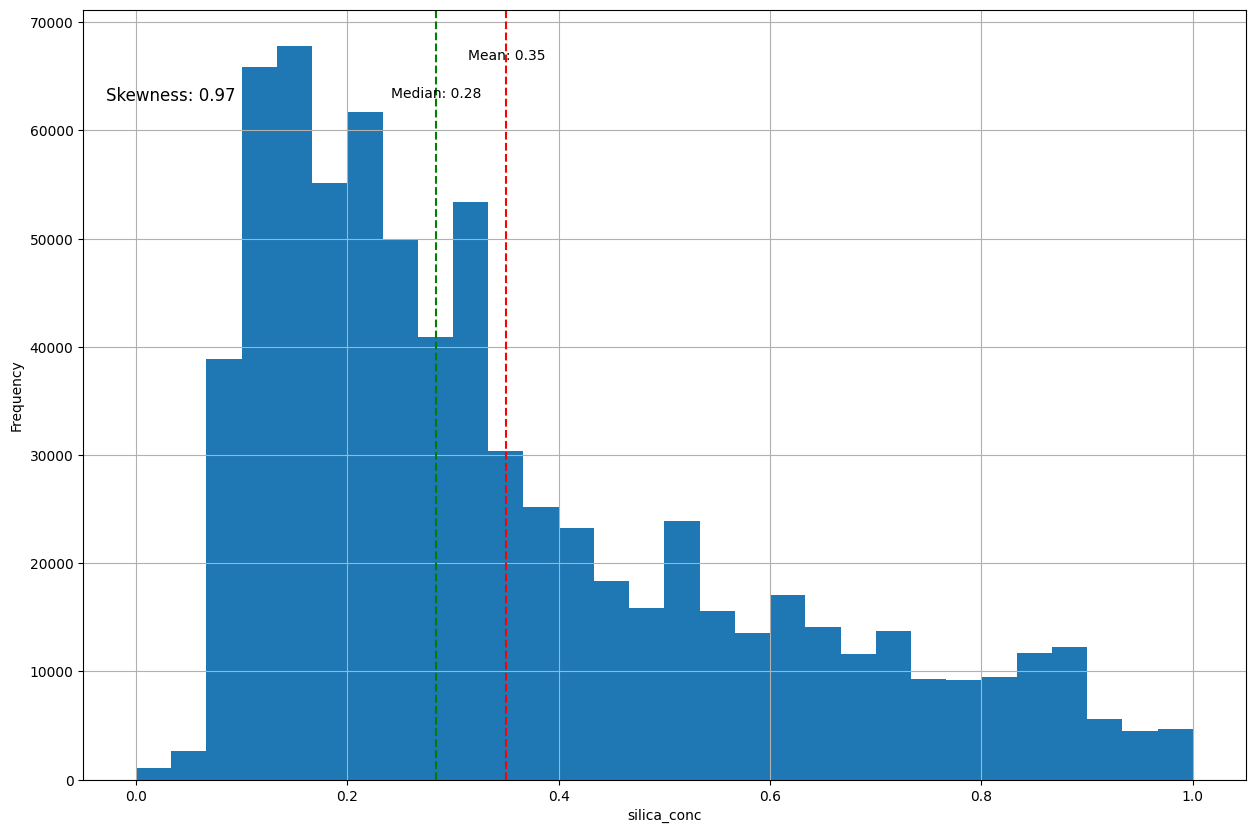

In [ ]:
from scipy.stats import skew

# Select the specific column for skewness calculation
data = flotation['silica_conc'].to_numpy()

# Calculate the skewness degree
skewness = skew(data)

fig, ax = plt.subplots(figsize=(15, 10))

# Plot the histogram
ax.hist(data, bins=30)
ax.set_xlabel('silica_conc')
ax.set_ylabel('Frequency')
ax.axvline(np.mean(data), color='r', linestyle='--')
ax.axvline(np.median(data), color='g', linestyle='--')

# Display the skewness degree in the plot
ax.text(0.02, 0.9, f"Skewness: {skewness:.2f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top')

# Display the mean and median values
ylim = ax.get_ylim()
y_range = ylim[1] - ylim[0]
ax.text(np.mean(data), ylim[1] - 0.05 * y_range,
         f"Mean: {np.mean(data):.2f}", color='black', fontsize=10,
         verticalalignment='top', horizontalalignment='center')
ax.text(np.median(data), ylim[1] - 0.1 * y_range,
         f"Median: {np.median(data):.2f}", color='black', fontsize=10,
         verticalalignment='top', horizontalalignment='center')
ax.grid(True)

plt.show()

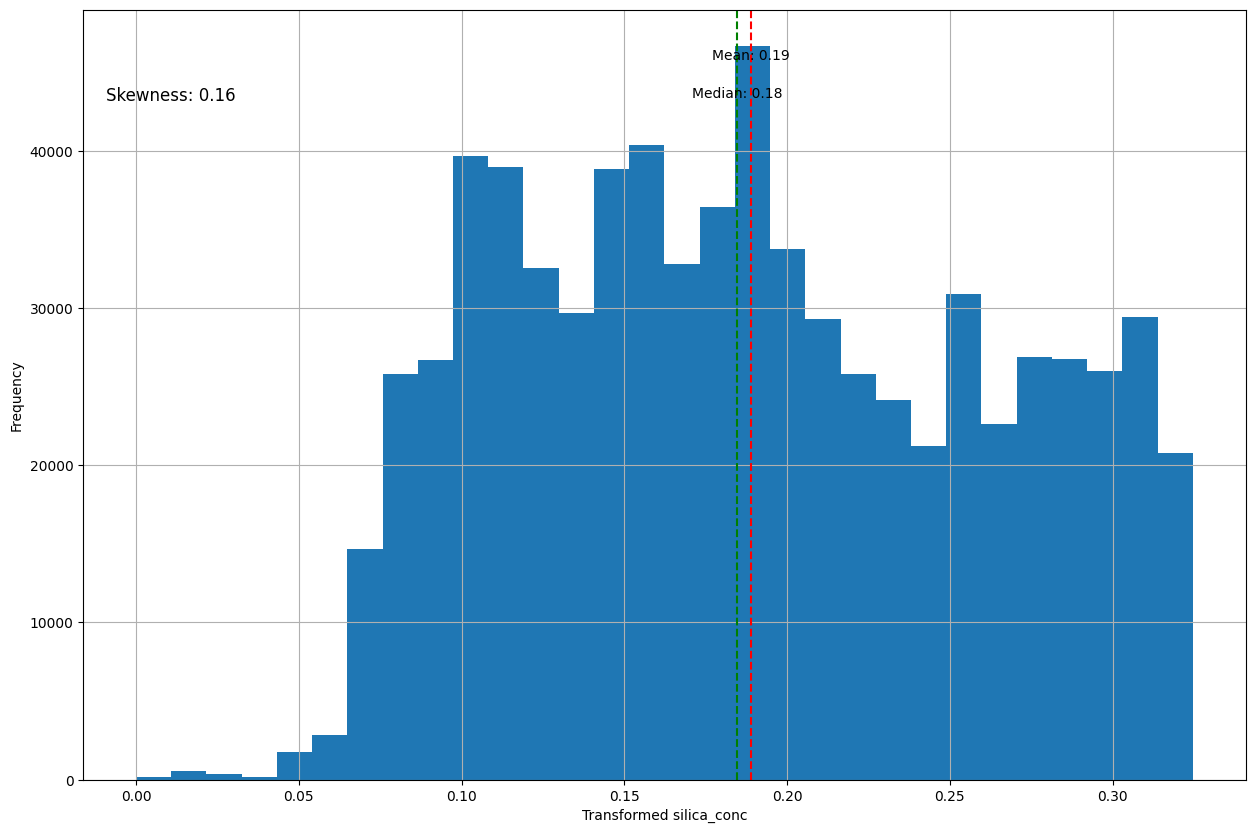

In [ ]:
from scipy.stats import boxcox

# Select the specific column for transformation
data = flotation['silica_conc'].to_numpy()

# Shift the data by a constant value
shifted_data = data - np.min(data) + 1  # Add 1 to ensure all values are positive

# Apply the Box-Cox transformation
data_transformed, lambda_value = boxcox(shifted_data)

# Update the 'silica_conc' column
flotation['silica_conc'] = data_transformed

# Calculate the skewness of the transformed data
skewness_transformed = skew(data_transformed)

# Plot the histogram of the transformed data
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(data_transformed, bins=30)
ax.set_xlabel('Transformed silica_conc')
ax.set_ylabel('Frequency')
ax.axvline(np.mean(data_transformed), color='r', linestyle='--')
ax.axvline(np.median(data_transformed), color='g', linestyle='--')

# Display the skewness degree in the plot
ax.text(0.02, 0.9, f"Skewness: {skewness_transformed:.2f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top')

# Display the mean and median values
ylim = ax.get_ylim()
y_range = ylim[1] - ylim[0]
ax.text(np.mean(data_transformed), ylim[1] - 0.05 * y_range,
         f"Mean: {np.mean(data_transformed):.2f}", color='black', fontsize=10,
         verticalalignment='top', horizontalalignment='center')
ax.text(np.median(data_transformed), ylim[1] - 0.1 * y_range,
         f"Median: {np.median(data_transformed):.2f}", color='black', fontsize=10,
         verticalalignment='top', horizontalalignment='center')

ax.grid(True)
plt.show()

###**5.8. Save manipulated dataset to new file**

In [ ]:
flotation.to_csv('/content/drive/My Drive/Flotation/Flotation_Plant_Manipulated.csv', index=False)